# Lista 1 - Deep Learning

Humberto Navarro - 20190029131

Lara Pontes - 20190031550

Tales Nobre - 20200025983

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
from tqdm import tqdm
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

## Questão 2
Implemente uma rede perceptron de múltiplas camadas e utilize-a para aproximar as funções abaixo. Em seguida, compare os resultados com as curvas exatas. No caso das letras(b) e (c), apresente também a curva do erro médio de treinamento com relação ao número de épocas e a curva do erro médio com o conjunto de validação.

**a)** a função lógica XOR

**b)** f(x) = log_10(x), onde 1 ≤ x ≤ 10

**c)** f(x) = 10x^5+ 5x^4+ 2x^3– 0.5x^2+ 3x + 2, onde 0 ≤ x ≤ 20

### a) Função lógica XOR

#### Criando o dataset

In [2]:
dataset = []
dataset.extend([[0, 0, 0]] * 2000)
dataset.extend([[1, 1, 0]] * 2000)
dataset.extend([[0, 1, 1]] * 2000)
dataset.extend([[1, 0, 1]] * 2000)

In [3]:
np.random.seed(42)
noisy_dataset = []
for item in dataset:
    noisy_item = [x + np.random.uniform(-0.2, 0.2) for x in item[:-1]]
    noisy_item.append(item[-1])
    noisy_dataset.append(noisy_item)

In [4]:
data = pd.DataFrame(noisy_dataset, columns=['x1', 'x2', 'y'])
data.head()

,x1,x2,y
0,-0.050184,0.180286,0
1,0.092798,0.039463,0
2,-0.137593,-0.137602,0
3,-0.176767,0.146470,0
4,0.040446,0.083229,0


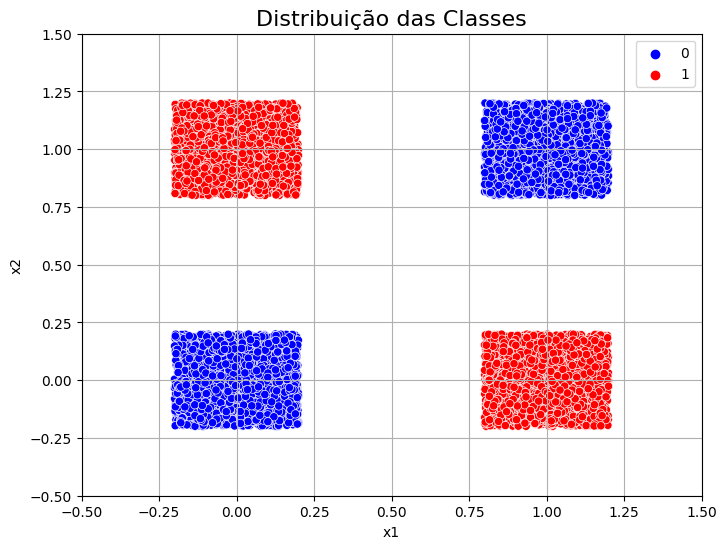

In [5]:
classes = data['y'].unique()

plt.figure(figsize=(8, 6))

sns.scatterplot(x=data.iloc[:, 0], y=data.iloc[:, 1], hue=data['y'], palette={0: 'blue', 1: 'red'})

plt.title("Distribuição das Classes", fontsize=16)
plt.grid()
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.legend(loc="best")

plt.show()

##### Preparando os dados

In [6]:
X = torch.tensor(data[['x1', 'x2']].values, dtype=torch.float32)
y = torch.tensor(data['y'].values, dtype=torch.long)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

#### Criando a Rede Neural

In [8]:
loaders = {
    'train': DataLoader(
        list(zip(X_train, y_train)),
        batch_size=32,
        shuffle=True
    ),
    'test': DataLoader(
        list(zip(X_test, y_test)),
        batch_size=32,
        shuffle=True
    )
}

In [9]:
class NeuralNet_a(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet_a, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.linear_stack(x)

In [10]:
model = NeuralNet_a(2, 7, 1)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.BCELoss()

##### Usando SGD como otimizador

In [11]:
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

epochs = 200

progress = tqdm(range(epochs*len(loaders['train'])))

for epoch in range(1, epochs+1):
    epoch_loss = []
    epoch_acc = []

    model.train()
    for data, target in loaders['train']:
        optimizer.zero_grad()
        output = model(data)
        target = target.unsqueeze(1)
        target = target.float()
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        acc = (output.round() == target).float().mean()
        epoch_loss.append(loss.item())
        epoch_acc.append(acc)
        progress.set_description(f"Epoch [{epoch}/{epochs}]")
        progress.set_postfix(loss=f"{loss.item():.6f}")
        progress.update(1)


    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            output = model(data)
            target = target.unsqueeze(1)
            target = target.float()
            test_loss += loss_fn(output, target).item()
            pred = output.round()
            correct += pred.eq(target.view_as(pred)).sum()

    test_loss /= len(loaders['test'].dataset)

    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(test_loss)
    test_acc_hist.append(correct / len(loaders['test'].dataset))

    if (correct / len(loaders['test'].dataset) >= 0.996) and (epoch % 10 == 0):
        print(f"\nAccuracy on epoch {epoch} = 100%. Finishing training...")
        break

    if epoch > 120:
        if (np.mean(test_acc_hist[-60:]) <= np.mean(test_acc_hist[-120:-60])) or (len(set(test_acc_hist[-50:])) == 1):
            print(f"\nAccuraccy of test set is not improving. Finishing training...")
            break

    print(f" Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders['test'].dataset)} ({100. * correct / len(loaders['test'].dataset):.2f}%)\n") if epoch % 5 == 0 else None

print(f"\nAccuracy: {correct}/{len(loaders['test'].dataset)} ({100. * correct / len(loaders['test'].dataset):.2f}%)\n")

Epoch [6/200]:   3%|▎         | 1053/40000 [00:03<02:06, 307.43it/s, loss=0.587557]

 Test set: Average loss: 0.0183, Accuracy: 1449/1600 (90.56%)



Epoch [10/200]:   5%|▍         | 1999/40000 [00:07<02:35, 244.74it/s, loss=0.419386]


Accuracy on epoch 10 = 100%. Finishing training...

Accuracy: 1599/1600 (99.94%)



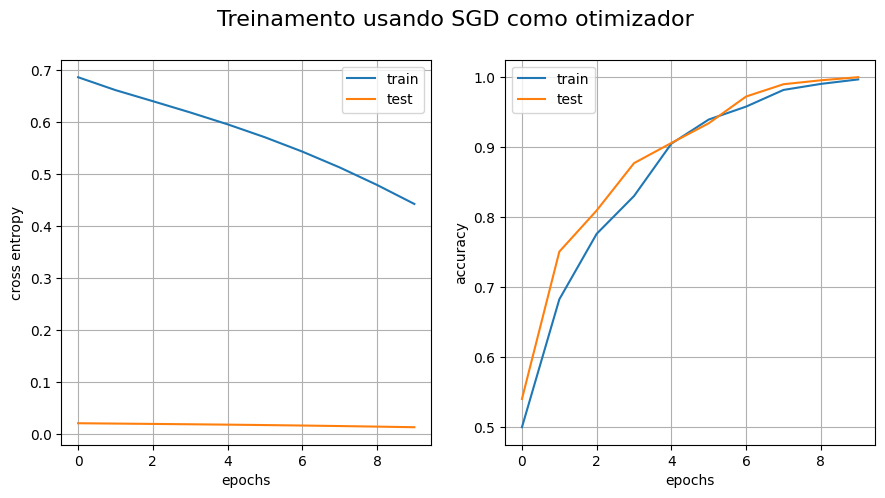

Epoch [10/200]:   5%|▌         | 2000/40000 [00:20<02:35, 244.74it/s, loss=0.419386]

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10.5, 5))
ax[0].plot(train_loss_hist, label="train")
ax[0].plot(test_loss_hist, label="test")
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("cross entropy")
ax[0].legend()
ax[0].grid();

ax[1].plot(train_acc_hist, label="train")
ax[1].plot(test_acc_hist, label="test")
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("accuracy")
ax[1].legend()
ax[1].grid();
fig.suptitle("Treinamento usando SGD como otimizador", fontsize=16);

In [13]:
xx, yy = np.meshgrid(np.linspace(-.5, 1.5, 1000), np.linspace(-.5, 1.5, 1000))
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.FloatTensor(grid_points)

In [14]:
with torch.no_grad():
    model.eval()
    predictions = model(grid_tensor).numpy()

limit = 0.5
class_pred = (predictions > limit).astype(int)


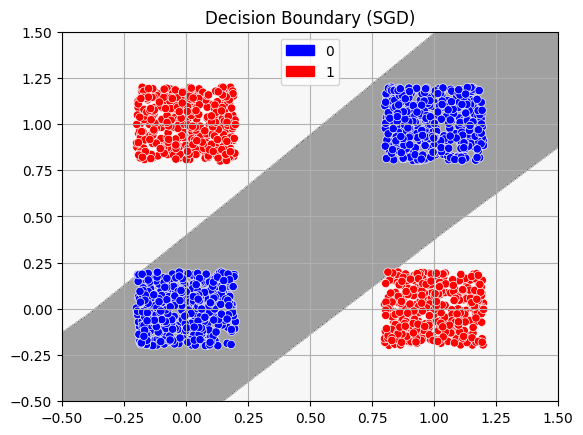

In [15]:
plt.contourf(xx, yy, class_pred.reshape(xx.shape), alpha=0.4, cmap='gray')

sns.scatterplot(x=X_test.numpy()[:, 0], y=X_test.numpy()[:, 1], hue=y_test,
                palette={0: 'blue', 1: 'red'}, legend=False)

plt.title('Decision Boundary (SGD)')

red_patch = mpatches.Patch(color='blue', label='0')
green_patch = mpatches.Patch(color='red', label='1')
plt.legend(handles=[red_patch, green_patch], loc='upper center')

plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.grid()

plt.show()

##### Usando Adam como otimizador

In [16]:
model2 = NeuralNet_a(2, 7, 1)
optimizer = optim.Adam(model2.parameters(), lr=1e-2)
loss_fn = nn.BCELoss()

In [17]:
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

epochs = 200

progress = tqdm(range(epochs*len(loaders['train'])))

for epoch in range(1, epochs+1):
    epoch_loss = []
    epoch_acc = []

    model2.train()
    for data, target in loaders['train']:
        optimizer.zero_grad()
        output = model2(data)
        target = target.unsqueeze(1)
        target = target.float()
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        acc = (output.round() == target).float().mean()
        epoch_loss.append(loss.item())
        epoch_acc.append(acc)
        progress.set_description(f"Epoch [{epoch}/{epochs}]")
        progress.set_postfix(loss=f"{loss.item():.6f}")
        progress.update(1)


    model2.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            output = model2(data)
            target = target.unsqueeze(1)
            target = target.float()
            test_loss += loss_fn(output, target).item()
            pred = output.round()
            correct += pred.eq(target.view_as(pred)).sum()

    test_loss /= len(loaders['test'].dataset)

    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(test_loss)
    test_acc_hist.append(correct / len(loaders['test'].dataset))

    if (correct / len(loaders['test'].dataset) >= 0.99) and (epoch % 10 == 0):
        print(f"\nAccuracy on epoch {epoch} = 100%. Finishing training...")
        break

    if epoch > 120:
        if (np.mean(test_acc_hist[-60:]) <= np.mean(test_acc_hist[-120:-60])) or (len(set(test_acc_hist[-50:])) == 1):
            print(f"\nAccuraccy of test set is not improving. Finishing training...")
            break

    print(f" Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders['test'].dataset)} ({100. * correct / len(loaders['test'].dataset):.0f}%)\n") if epoch % 5 == 0 else None

print(f"\nAccuracy: {correct}/{len(loaders['test'].dataset)} ({100. * correct / len(loaders['test'].dataset):.0f}%)\n")

Epoch [10/200]:   5%|▌         | 2000/40000 [00:30<09:38, 65.67it/s, loss=0.419386] 



 Test set: Average loss: 0.0004, Accuracy: 1600/1600 (100%)



Epoch [6/200]:   3%|▎         | 1030/40000 [00:06<03:46, 172.15it/s, loss=0.012344]


Accuracy on epoch 10 = 100%. Finishing training...

Accuracy: 1600/1600 (100%)



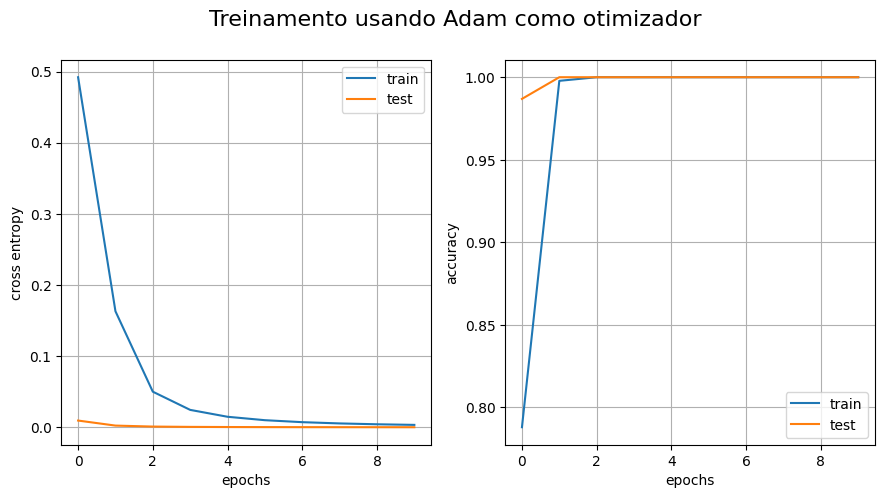

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10.5, 5))
ax[0].plot(train_loss_hist, label="train")
ax[0].plot(test_loss_hist, label="test")
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("cross entropy")
ax[0].legend()
ax[0].grid();

ax[1].plot(train_acc_hist, label="train")
ax[1].plot(test_acc_hist, label="test")
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("accuracy")
ax[1].legend()
ax[1].grid();
fig.suptitle("Treinamento usando Adam como otimizador", fontsize=16);

In [19]:
model2.eval()
with torch.no_grad():
    output = model2(torch.Tensor([[0, 0], [1, 1], [0, 1], [1, 0]]))
    print(output.round())


tensor([[0.],
        [0.],
        [1.],
        [1.]])


In [20]:
xx, yy = np.meshgrid(np.linspace(-.5, 1.5, 1000), np.linspace(-.5, 1.5, 1000))
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.FloatTensor(grid_points)

In [21]:
with torch.no_grad():
    model2.eval()
    predictions = model2(grid_tensor).numpy()

limit = 0.5
class_pred = (predictions > limit).astype(int)


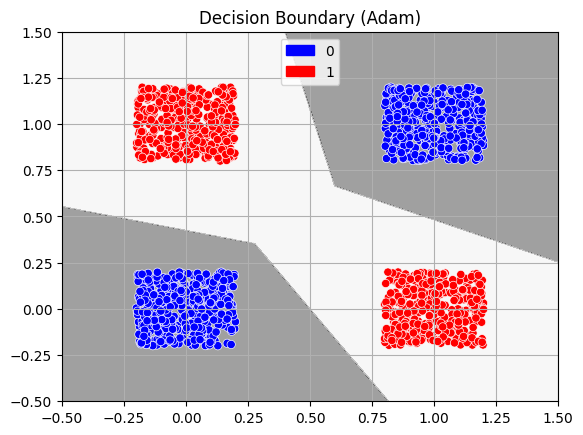

In [22]:
plt.contourf(xx, yy, class_pred.reshape(xx.shape), alpha=0.4, cmap='gray')

sns.scatterplot(x=X_test.numpy()[:, 0], y=X_test.numpy()[:, 1], hue=y_test,
                palette={0: 'blue', 1: 'red'}, legend=False)

plt.title('Decision Boundary (Adam)')

red_patch = mpatches.Patch(color='blue', label='0')
green_patch = mpatches.Patch(color='red', label='1')
plt.legend(handles=[red_patch, green_patch], loc='upper center')

plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.grid()

plt.show()

### b) $f(x) = log_{10}(x), 1 \leq x \leq 10$

#### Criando o dataset

In [79]:
X = np.linspace(1, 10, 4000)
y = np.log10(X)

In [80]:
data = pd.DataFrame([X, y]).T
data.columns = ['X', 'y']
data

,X,y
0,1.000000,0.000000
1,1.002251,0.000976
2,1.004501,0.001950
3,1.006752,0.002922
4,1.009002,0.003892
...,...,...
3995,9.990998,0.999609
3996,9.993248,0.999707
3997,9.995499,0.999804
3998,9.997749,0.999902


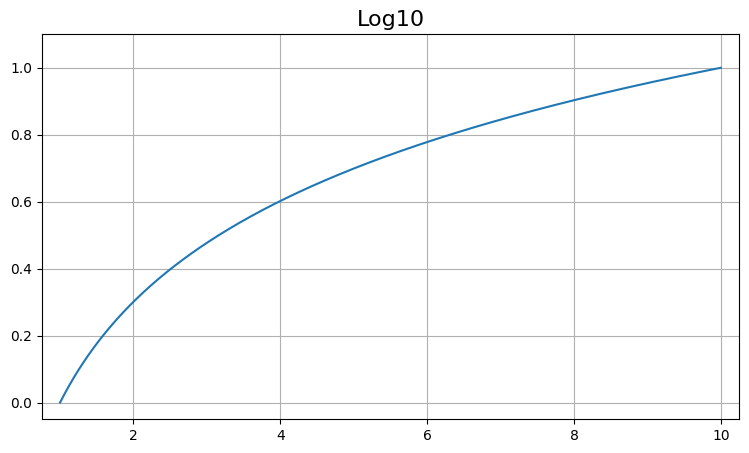

In [81]:
plt.figure(figsize=(9, 5))
plt.plot(data['X'], data['y'])
plt.xlim(.75, 10.25)
plt.ylim(-0.05, 1.1)
plt.grid()
plt.title('Log10', fontsize=16);

#### Criando a Rede Neural

In [82]:
X = torch.tensor(data[['X']].values, dtype=torch.float32)
y = torch.tensor(data['y'].values, dtype=torch.float32)

In [83]:
class NeuralNet_b(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet_b, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        return self.linear_stack(x)

##### Abordagem 2 (Usando como teste os 20% finais do dataset)

In [84]:
X_train = X[:int(len(X)*.8)]
y_train = y[:int(len(y)*.8)]
X_test = X[int(len(X)*.8):]
y_test = y[int(len(y)*.8):]

In [85]:
loaders = {
    'train': DataLoader(
        list(zip(X_train, y_train)),
        batch_size=32,
        shuffle=True
    ),
    'test': DataLoader(
        list(zip(X_test, y_test)),
        batch_size=32,
        shuffle=True
    )
}

In [86]:
model2 = NeuralNet_b(1, 10, 1)
optimizer = optim.Adam(model2.parameters(), lr=2e-3)
loss_fn = nn.MSELoss()

In [87]:
train_loss_hist = []
test_loss_hist = []

epochs = 200

progress = tqdm(range(epochs*len(loaders['train'])))

for epoch in range(1, epochs+1):
    test_loss = []
    epoch_loss = []
    epoch_acc = []

    model2.train()
    for data, target in loaders['train']:
        optimizer.zero_grad()
        output = model2(data)
        target = target.unsqueeze(1)
        target = target.float()
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
        progress.set_description(f"Epoch [{epoch}/{epochs}]")
        progress.set_postfix(loss=f"{loss.item():.6f}")
        progress.update(1)

    model2.eval()
    with torch.no_grad():
        for data, target in loaders['test']:
            output = model2(data)
            mse = float(loss_fn(output, target))
            test_loss.append(mse)

    train_loss_hist.append(np.mean(epoch_loss))
    test_loss_hist.append(np.mean(test_loss))

    if epoch > 120:
        if np.mean(test_loss_hist[-60:]) <= np.mean(test_loss_hist[-120:-60]):
            print(f"\nAccuraccy of test set is not improving. Finishing training...")
            break

    print(f" Test set: Average loss: {np.mean(test_loss):.4f}") if epoch % 5 == 0 else None

Epoch [10/200]:   5%|▌         | 2000/40000 [00:22<07:10, 88.36it/s, loss=0.000329] 

Epoch [6/200]:   3%|▎         | 510/20000 [00:09<05:53, 55.07it/s, loss=0.000402]

 Test set: Average loss: 0.0040


 Test set: Average loss: 0.0034



Epoch [16/200]:   8%|▊         | 1510/20000 [00:27<05:52, 52.48it/s, loss=0.000192]

 Test set: Average loss: 0.0030


 Test set: Average loss: 0.0025


 Test set: Average loss: 0.0016


 Test set: Average loss: 0.0013


 Test set: Average loss: 0.0012


Epoch [41/200]:  20%|██        | 4009/20000 [01:12<05:18, 50.23it/s, loss=0.000002]

 Test set: Average loss: 0.0011


 Test set: Average loss: 0.0011


 Test set: Average loss: 0.0011


 Test set: Average loss: 0.0011



Epoch [61/200]:  30%|███       | 6010/20000 [01:47<04:17, 54.35it/s, loss=0.000001]

 Test set: Average loss: 0.0011


 Test set: Average loss: 0.0011


Epoch [66/200]:  33%|███▎      | 6510/20000 [01:56<04:18, 52.11it/s, loss=0.000000]

 Test set: Average loss: 0.0011


 Test set: Average loss: 0.0011


Epoch [76/200]:  38%|███▊      | 7509/20000 [02:14<03:54, 53.16it/s, loss=0.000001]

 Test set: Average loss: 0.0011



Epoch [86/200]:  43%|████▎     | 8510/20000 [02:31<03:37, 52.92it/s, loss=0.000000]

 Test set: Average loss: 0.0011



Epoch [91/200]:  45%|████▌     | 9009/20000 [02:40<03:16, 55.80it/s, loss=0.000000]

 Test set: Average loss: 0.0011


 Test set: Average loss: 0.0011


Epoch [96/200]:  48%|████▊     | 9511/20000 [02:49<03:07, 55.97it/s, loss=0.000000]


 Test set: Average loss: 0.0011


Epoch [101/200]:  50%|█████     | 10008/20000 [02:57<02:58, 56.02it/s, loss=0.000000]

 Test set: Average loss: 0.0011


 Test set: Average loss: 0.0011


 Test set: Average loss: 0.0012


 Test set: Average loss: 0.0012


Epoch [121/200]:  60%|██████    | 12033/20000 [03:25<00:45, 176.59it/s, loss=0.000000]


Accuraccy of test set is not improving. Finishing training...


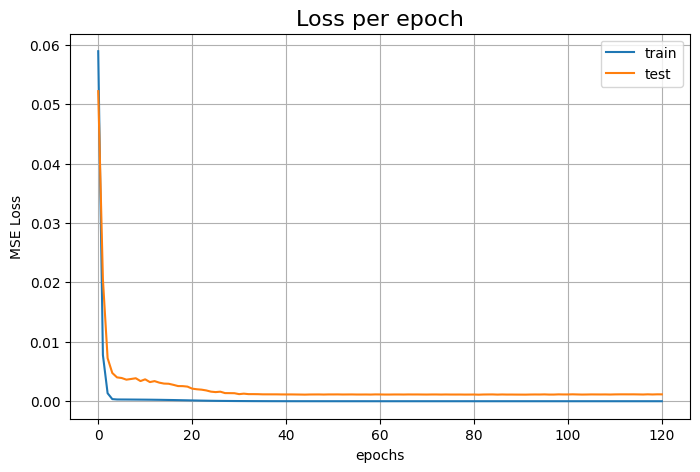

In [88]:
plt.figure(figsize=(8, 5))
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("MSE Loss")
plt.title("Loss per epoch", fontsize=16)
plt.legend()
plt.grid();

In [89]:
model2.eval()
with torch.no_grad():
    output = model2(X_test)

(0.75, 10.25)

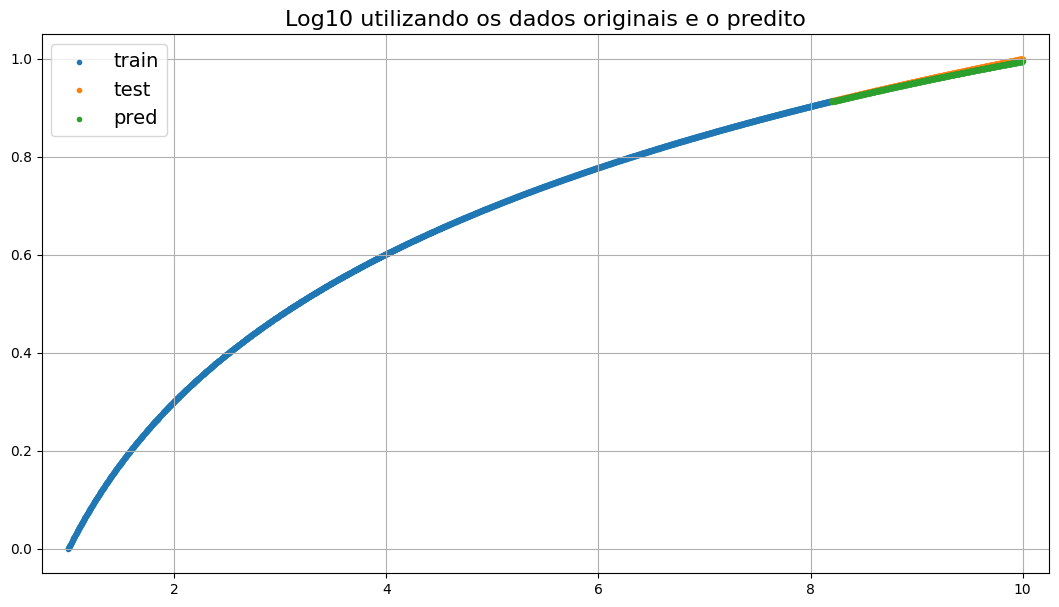

In [90]:
plt.figure(figsize=(13, 7))
plt.scatter(list(X_train.numpy().ravel()), list(y_train.numpy().ravel()), label='train', marker='.')
plt.scatter(list(X_test.numpy().ravel()), list(y_test.numpy().ravel()), label='test', marker='.')
plt.scatter(list(X_test.numpy().ravel()), list(output.numpy().ravel()), label='pred', marker='.')
plt.grid()
plt.title('Log10 utilizando os dados originais e o predito', fontsize=16)
plt.legend(fontsize='14')
plt.xlim(.75, 10.25)

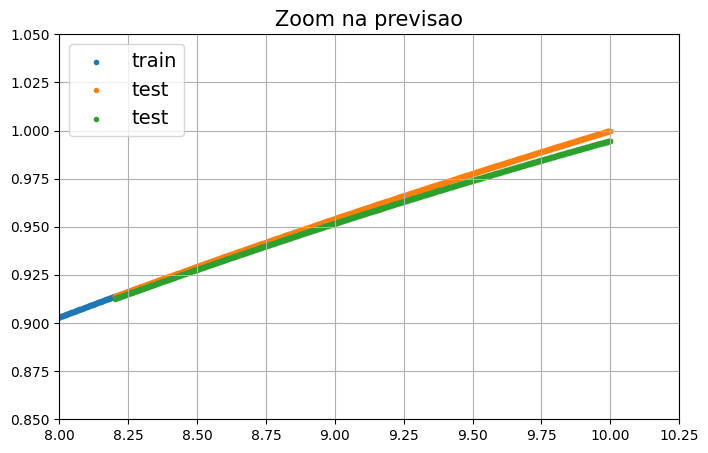

In [91]:
plt.figure(figsize=(8, 5))
plt.scatter(list(X_train.numpy().ravel()), list(y_train.numpy().ravel()), label='train', marker='.')
plt.scatter(list(X_test.numpy().ravel()), list(y_test.numpy().ravel()), label='test', marker='.')
plt.scatter(list(X_test.numpy().ravel()), list(output.numpy().ravel()), label='test', marker='.')
plt.grid()
plt.title('Zoom na previsao', fontsize=15)
plt.legend(fontsize='14')
plt.xlim(8, 10.25)
plt.ylim(0.85, 1.05);

In [92]:
# RMSE
torch.sqrt(loss_fn(output, y_test))

tensor(0.0345)

### c) $f(x) = 10x^5 + 5x^4 + 2x^3 - 0.5x^2 + 3x + 2, 0 \leq x \leq 8$

#### Criando o dataset

In [18]:
def f(x):
    return (10*(x**5)) + (5*(x**4)) + (2*(x**3)) - (0.5*(x**2)) + (3*x) + 2

In [19]:
X = np.linspace(0, 8, 4000)
y = f(X)

In [20]:
data = pd.DataFrame([X, y]).T
data.columns = ['X', 'y']
data

,X,y
0,0.000000,2.000000
1,0.002001,2.006000
2,0.004001,2.011995
3,0.006002,2.017987
4,0.008002,2.023975
...,...,...
3995,7.991998,347457.618116
3996,7.993998,347887.076360
3997,7.995999,348316.959212
3998,7.997999,348747.266987


Text(0.5, 1.0, 'f(x) = 10x^5 + 5x^4 + 2x^3 - 0.5x^2 + 3x + 2')

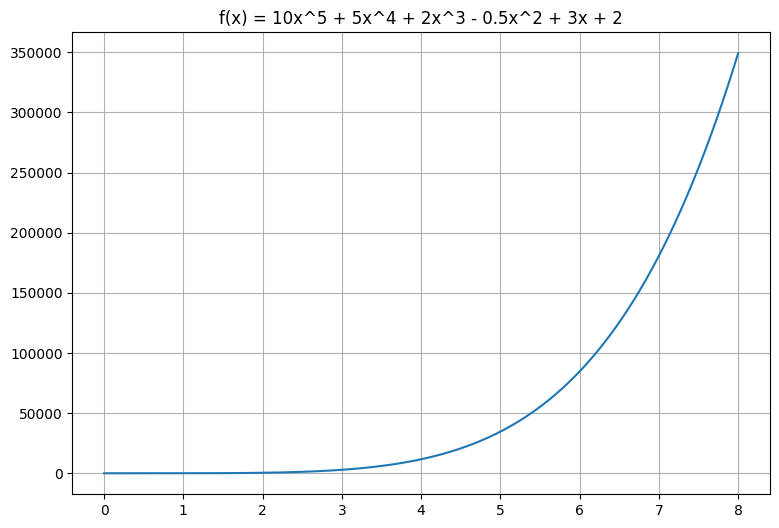

In [21]:
plt.figure(figsize=(9, 6))
plt.plot(data['X'], data['y'])
plt.grid()
plt.title("f(x) = 10x^5 + 5x^4 + 2x^3 - 0.5x^2 + 3x + 2")

#### Criando a Rede Neural

In [22]:
X = torch.tensor(data[['X']].values, dtype=torch.float32)
y = torch.tensor(data['y'].values, dtype=torch.float32)

In [23]:
class NeuralNet_c1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet_c1, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size[0]),
            nn.ReLU(),
            nn.Linear(hidden_size[0], hidden_size[1]),
            nn.ReLU(),
            nn.Linear(hidden_size[1], hidden_size[2]),
            nn.ReLU(),
            nn.Linear(hidden_size[2], hidden_size[3]),
            nn.ReLU(),
            nn.Linear(hidden_size[3], hidden_size[4]),
            nn.ReLU(),
            nn.Linear(hidden_size[4], output_size),
        )

    def forward(self, x):
        return self.linear_stack(x)

#####  Usando como teste os 20% finais do dataset

In [24]:
X_train = X[:int(len(X)*.8)]
y_train = y[:int(len(y)*.8)]
X_test = X[int(len(X)*.8):]
y_test = y[int(len(y)*.8):]

In [25]:
loaders = {
    'train': DataLoader(
        list(zip(X_train, y_train)),
        batch_size=64,
        shuffle=True
    ),
    'test': DataLoader(
        list(zip(X_test, y_test)),
        batch_size=64,
        shuffle=True
    )
}

In [45]:
model_c2 = NeuralNet_c1(1, [128, 128, 64, 64, 32], 1)
optimizer = optim.Adam(model_c2.parameters(), lr=0.1)
loss_fn = nn.MSELoss()

In [46]:
train_loss_hist = []
test_loss_hist = []

epochs = 800

progress = tqdm(range(epochs*len(loaders['train'])))

for epoch in range(1, epochs+1):
    test_loss = []
    epoch_loss = []
    epoch_acc = []

    model_c2.train()
    for data, target in loaders['train']:
        optimizer.zero_grad()
        output = model_c2(data)
        target = target.unsqueeze(1)
        target = target.float()
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
        progress.set_description(f"Epoch [{epoch}/{epochs}]")
        progress.set_postfix(loss=f"{loss.item():.6f}")
        progress.update(1)

    model_c2.eval()
    with torch.no_grad():
        for data, target in loaders['test']:
            output = model_c2(data)
            mse = float(loss_fn(output, target))
            test_loss.append(mse)

    train_loss_hist.append(np.mean(epoch_loss))
    test_loss_hist.append(np.mean(test_loss))

    print(f" Test set: Average loss: {np.mean(test_loss):.4f}") if epoch % 5 == 0 else None

Epoch [6/800]:   1%|          | 270/40000 [00:02<05:55, 111.62it/s, loss=12308511.000000] 

 Test set: Average loss: 8141665122.4615


Epoch [11/800]:   1%|▏         | 534/40000 [00:04<03:51, 170.21it/s, loss=693359.375000]  

 Test set: Average loss: 7664686670.7692


Epoch [16/800]:   2%|▏         | 780/40000 [00:05<04:01, 162.60it/s, loss=257925.218750]  

 Test set: Average loss: 7431155160.6154


Epoch [21/800]:   3%|▎         | 1028/40000 [00:07<04:28, 145.37it/s, loss=672986.562500]  

 Test set: Average loss: 9906782011.0769


Epoch [26/800]:   3%|▎         | 1257/40000 [00:09<06:22, 101.36it/s, loss=262426.125000]  

 Test set: Average loss: 7366076258.4615


Epoch [31/800]:   4%|▍         | 1526/40000 [00:11<04:31, 141.89it/s, loss=117251728.000000]

 Test set: Average loss: 18741471704.6154


Epoch [36/800]:   4%|▍         | 1779/40000 [00:13<03:53, 163.39it/s, loss=1775194.750000]  

 Test set: Average loss: 8029513058.4615


Epoch [41/800]:   5%|▌         | 2020/40000 [00:15<05:24, 116.97it/s, loss=8826902.000000] 

 Test set: Average loss: 8805266432.0000


Epoch [46/800]:   6%|▌         | 2273/40000 [00:17<05:08, 122.31it/s, loss=3621757.500000] 

 Test set: Average loss: 8288937590.1538


Epoch [51/800]:   6%|▋         | 2524/40000 [00:19<04:54, 127.10it/s, loss=4005875.500000] 

 Test set: Average loss: 8542787584.0000


Epoch [56/800]:   7%|▋         | 2773/40000 [00:21<04:48, 129.15it/s, loss=1329483.625000] 

 Test set: Average loss: 9162745777.2308


Epoch [61/800]:   8%|▊         | 3026/40000 [00:23<04:46, 129.00it/s, loss=1318754.625000]

 Test set: Average loss: 8437609944.6154


Epoch [66/800]:   8%|▊         | 3276/40000 [00:25<04:57, 123.39it/s, loss=3970509.250000] 

 Test set: Average loss: 7096127094.1538


Epoch [71/800]:   9%|▉         | 3522/40000 [00:27<04:46, 127.50it/s, loss=2027556.250000] 

 Test set: Average loss: 7622404726.1538


Epoch [76/800]:   9%|▉         | 3774/40000 [00:29<04:40, 129.01it/s, loss=144984.859375]  

 Test set: Average loss: 7368791079.3846


Epoch [81/800]:  10%|█         | 4024/40000 [00:31<04:46, 125.46it/s, loss=134927.671875]  

 Test set: Average loss: 7538074033.2308


Epoch [86/800]:  11%|█         | 4275/40000 [00:33<04:57, 120.14it/s, loss=233116.593750]  

 Test set: Average loss: 7556543409.2308


Epoch [91/800]:  11%|█▏        | 4517/40000 [00:35<04:57, 119.27it/s, loss=140169.093750]  

 Test set: Average loss: 7335716942.7692


Epoch [96/800]:  12%|█▏        | 4772/40000 [00:37<04:35, 127.64it/s, loss=7337031.500000]

 Test set: Average loss: 7223206439.3846


Epoch [101/800]:  13%|█▎        | 5025/40000 [00:39<04:31, 128.91it/s, loss=617830.437500] 

 Test set: Average loss: 7285875593.8462


Epoch [106/800]:  13%|█▎        | 5274/40000 [00:41<04:36, 125.77it/s, loss=106191.375000]  

 Test set: Average loss: 7280735940.9231


Epoch [111/800]:  14%|█▍        | 5521/40000 [00:43<04:39, 123.40it/s, loss=107440.312500]  

 Test set: Average loss: 8147787972.9231


Epoch [116/800]:  14%|█▍        | 5773/40000 [00:45<04:44, 120.37it/s, loss=27441.800781]   

 Test set: Average loss: 7173127168.0000


Epoch [121/800]:  15%|█▌        | 6023/40000 [00:47<04:43, 119.80it/s, loss=4363932.500000]  

 Test set: Average loss: 6903867116.3077


Epoch [126/800]:  16%|█▌        | 6274/40000 [00:49<04:09, 135.02it/s, loss=4717.009277]    

 Test set: Average loss: 7026239488.0000


Epoch [131/800]:  16%|█▋        | 6523/40000 [00:51<04:24, 126.80it/s, loss=20923.230469]   

 Test set: Average loss: 7283958114.4615


Epoch [136/800]:  17%|█▋        | 6774/40000 [00:53<04:08, 133.93it/s, loss=2038576.250000]  

 Test set: Average loss: 6940786569.8462


Epoch [141/800]:  18%|█▊        | 7024/40000 [00:55<04:07, 133.42it/s, loss=9496098.000000] 

 Test set: Average loss: 7165467372.3077


Epoch [146/800]:  18%|█▊        | 7275/40000 [00:57<04:02, 134.72it/s, loss=192574.000000]   

 Test set: Average loss: 7052256295.3846


Epoch [151/800]:  19%|█▉        | 7523/40000 [00:59<04:04, 132.56it/s, loss=90838.328125]  

 Test set: Average loss: 7247943601.2308


Epoch [156/800]:  19%|█▉        | 7774/40000 [01:01<04:16, 125.40it/s, loss=45905.707031]   

 Test set: Average loss: 7545346284.3077


Epoch [161/800]:  20%|██        | 8021/40000 [01:03<04:46, 111.62it/s, loss=5656.863281]   

 Test set: Average loss: 7180311867.0769


Epoch [166/800]:  21%|██        | 8267/40000 [01:05<04:53, 108.08it/s, loss=129825.562500]  

 Test set: Average loss: 7648422163.6923


Epoch [171/800]:  21%|██▏       | 8525/40000 [01:07<04:20, 120.72it/s, loss=8263.885742]   

 Test set: Average loss: 7328865595.0769


Epoch [176/800]:  22%|██▏       | 8773/40000 [01:09<04:11, 123.92it/s, loss=288191.812500]  

 Test set: Average loss: 7951809536.0000


Epoch [181/800]:  23%|██▎       | 9017/40000 [01:11<03:55, 131.50it/s, loss=29432.250000]   

 Test set: Average loss: 7601880300.3077


Epoch [186/800]:  23%|██▎       | 9275/40000 [01:13<03:45, 136.18it/s, loss=161818.156250]  

 Test set: Average loss: 7775025742.7692


Epoch [191/800]:  24%|██▍       | 9526/40000 [01:15<03:51, 131.67it/s, loss=34810.515625]  

 Test set: Average loss: 7787972962.4615


Epoch [196/800]:  24%|██▍       | 9776/40000 [01:17<03:47, 132.69it/s, loss=1075129.750000] 

 Test set: Average loss: 8100671645.5385


Epoch [201/800]:  25%|██▌       | 10021/40000 [01:19<04:12, 118.96it/s, loss=83787696.000000]

 Test set: Average loss: 8236069533.5385


Epoch [206/800]:  26%|██▌       | 10270/40000 [01:20<03:53, 127.09it/s, loss=141943.312500]   

 Test set: Average loss: 8648494001.2308


Epoch [211/800]:  26%|██▋       | 10525/40000 [01:22<03:37, 135.40it/s, loss=128501.195312]

 Test set: Average loss: 8997196209.2308


Epoch [216/800]:  27%|██▋       | 10776/40000 [01:24<03:33, 137.03it/s, loss=82329.789062] 

 Test set: Average loss: 9088111497.8462


Epoch [221/800]:  28%|██▊       | 11022/40000 [01:26<03:56, 122.63it/s, loss=1265327.875000]

 Test set: Average loss: 9254236120.6154


Epoch [226/800]:  28%|██▊       | 11274/40000 [01:29<03:54, 122.51it/s, loss=67537.218750]  

 Test set: Average loss: 9143889841.2308


Epoch [231/800]:  29%|██▉       | 11525/40000 [01:31<03:56, 120.49it/s, loss=2433037.250000]

 Test set: Average loss: 9386092110.7692


Epoch [236/800]:  29%|██▉       | 11776/40000 [01:33<03:34, 131.45it/s, loss=257390.515625]  

 Test set: Average loss: 8681259204.9231


Epoch [241/800]:  30%|███       | 12021/40000 [01:34<03:40, 126.86it/s, loss=114195.140625] 

 Test set: Average loss: 9037034220.3077


Epoch [246/800]:  31%|███       | 12273/40000 [01:36<03:49, 120.91it/s, loss=154770.953125] 

 Test set: Average loss: 9195444027.0769


Epoch [251/800]:  31%|███▏      | 12520/40000 [01:38<03:52, 118.10it/s, loss=810117.250000] 

 Test set: Average loss: 9076369801.8462


Epoch [256/800]:  32%|███▏      | 12772/40000 [01:40<03:54, 116.07it/s, loss=211168.109375]  

 Test set: Average loss: 8940603076.9231


Epoch [261/800]:  33%|███▎      | 13017/40000 [01:42<03:19, 135.45it/s, loss=965355.375000]  

 Test set: Average loss: 9808100352.0000


Epoch [266/800]:  33%|███▎      | 13274/40000 [01:44<03:20, 132.99it/s, loss=1199319.625000]

 Test set: Average loss: 9895970422.1538


Epoch [271/800]:  34%|███▍      | 13523/40000 [01:46<03:13, 136.99it/s, loss=395964.500000]  

 Test set: Average loss: 10562376782.7692


Epoch [276/800]:  34%|███▍      | 13774/40000 [01:48<03:18, 131.93it/s, loss=319523.281250]  

 Test set: Average loss: 9982819170.4615


Epoch [281/800]:  35%|███▌      | 14026/40000 [01:50<03:19, 129.98it/s, loss=373583.562500]  

 Test set: Average loss: 9587093976.6154


Epoch [286/800]:  36%|███▌      | 14272/40000 [01:52<03:30, 122.10it/s, loss=360854.750000] 

 Test set: Average loss: 9945627569.2308


Epoch [291/800]:  36%|███▋      | 14521/40000 [01:54<03:11, 132.83it/s, loss=211899.515625] 

 Test set: Average loss: 10009446084.9231


Epoch [296/800]:  37%|███▋      | 14774/40000 [01:56<03:16, 128.59it/s, loss=3004783.000000] 

 Test set: Average loss: 9152047104.0000


Epoch [301/800]:  38%|███▊      | 15025/40000 [01:58<03:08, 132.22it/s, loss=236882.312500]  

 Test set: Average loss: 10023004987.0769


Epoch [306/800]:  38%|███▊      | 15272/40000 [02:00<03:07, 131.79it/s, loss=2484928.750000]

 Test set: Average loss: 10074920329.8462


Epoch [311/800]:  39%|███▉      | 15523/40000 [02:02<03:05, 132.01it/s, loss=198906.328125] 

 Test set: Average loss: 9713134552.6154


Epoch [316/800]:  39%|███▉      | 15774/40000 [02:04<03:15, 123.70it/s, loss=315394.312500] 

 Test set: Average loss: 9674388243.6923


Epoch [321/800]:  40%|████      | 16023/40000 [02:06<03:18, 120.56it/s, loss=2190981.000000] 

 Test set: Average loss: 9530228617.8462


Epoch [326/800]:  41%|████      | 16263/40000 [02:08<03:37, 108.97it/s, loss=1671436.000000] 

 Test set: Average loss: 9568894700.3077


Epoch [331/800]:  41%|████▏     | 16524/40000 [02:09<02:52, 135.80it/s, loss=282195.562500] 

 Test set: Average loss: 9807699298.4615


Epoch [336/800]:  42%|████▏     | 16774/40000 [02:11<02:56, 131.68it/s, loss=208836.187500] 

 Test set: Average loss: 9874657516.3077


Epoch [341/800]:  43%|████▎     | 17023/40000 [02:13<02:49, 135.67it/s, loss=740669.875000] 

 Test set: Average loss: 9522244647.3846


Epoch [346/800]:  43%|████▎     | 17276/40000 [02:15<02:53, 131.26it/s, loss=281108.156250] 

 Test set: Average loss: 9928602466.4615


Epoch [351/800]:  44%|████▍     | 17524/40000 [02:17<02:50, 131.93it/s, loss=106963.500000]  

 Test set: Average loss: 9874026692.9231


Epoch [356/800]:  44%|████▍     | 17775/40000 [02:19<02:45, 134.65it/s, loss=177207.093750] 

 Test set: Average loss: 9628153383.3846


Epoch [361/800]:  45%|████▌     | 18025/40000 [02:21<02:48, 130.74it/s, loss=187764.484375]  

 Test set: Average loss: 9628163584.0000


Epoch [366/800]:  46%|████▌     | 18273/40000 [02:23<02:50, 127.22it/s, loss=425620.500000]  

 Test set: Average loss: 8679546368.0000


Epoch [371/800]:  46%|████▋     | 18522/40000 [02:25<02:46, 129.09it/s, loss=123901.992188] 

 Test set: Average loss: 9498599542.1538


Epoch [376/800]:  47%|████▋     | 18775/40000 [02:27<02:38, 133.73it/s, loss=228228.328125] 

 Test set: Average loss: 9471730018.4615


Epoch [381/800]:  48%|████▊     | 19027/40000 [02:29<02:37, 133.03it/s, loss=133054.000000] 

 Test set: Average loss: 9347612514.4615


Epoch [386/800]:  48%|████▊     | 19277/40000 [02:31<02:38, 130.71it/s, loss=231385.906250]  

 Test set: Average loss: 9199346806.1538


Epoch [391/800]:  49%|████▉     | 19524/40000 [02:33<02:38, 129.49it/s, loss=162850.500000] 

 Test set: Average loss: 9467344068.9231


Epoch [396/800]:  49%|████▉     | 19776/40000 [02:35<02:35, 130.27it/s, loss=1142169.875000]

 Test set: Average loss: 9445707815.3846


Epoch [401/800]:  50%|█████     | 20023/40000 [02:37<02:46, 120.23it/s, loss=108300.640625] 

 Test set: Average loss: 9543837459.6923


Epoch [406/800]:  51%|█████     | 20272/40000 [02:39<02:52, 114.17it/s, loss=520894.750000] 

 Test set: Average loss: 9545640605.5385


Epoch [411/800]:  51%|█████▏    | 20517/40000 [02:41<02:35, 125.34it/s, loss=431167.843750] 

 Test set: Average loss: 9508975340.3077


Epoch [416/800]:  52%|█████▏    | 20770/40000 [02:43<02:34, 124.64it/s, loss=358677.968750]  

 Test set: Average loss: 9651931332.9231


Epoch [421/800]:  53%|█████▎    | 21025/40000 [02:45<02:30, 125.76it/s, loss=200679.531250] 

 Test set: Average loss: 9694252189.5385


Epoch [426/800]:  53%|█████▎    | 21272/40000 [02:47<02:30, 124.37it/s, loss=1388643.250000]

 Test set: Average loss: 9234019091.6923


Epoch [431/800]:  54%|█████▍    | 21523/40000 [02:49<02:27, 125.32it/s, loss=211314.359375]  

 Test set: Average loss: 9284658097.2308


Epoch [436/800]:  54%|█████▍    | 21774/40000 [02:51<02:25, 125.49it/s, loss=190549.078125]

 Test set: Average loss: 9184544137.8462


Epoch [441/800]:  55%|█████▌    | 22020/40000 [02:53<02:20, 128.21it/s, loss=220535.593750] 

 Test set: Average loss: 9528372539.0769


Epoch [446/800]:  56%|█████▌    | 22274/40000 [02:55<02:18, 127.72it/s, loss=218183.765625] 

 Test set: Average loss: 9338008615.3846


Epoch [451/800]:  56%|█████▋    | 22523/40000 [02:58<02:21, 123.83it/s, loss=600907.500000] 

 Test set: Average loss: 9081077956.9231


Epoch [456/800]:  57%|█████▋    | 22774/40000 [03:00<02:15, 126.78it/s, loss=474225.250000]  

 Test set: Average loss: 8784116066.4615


Epoch [461/800]:  58%|█████▊    | 23024/40000 [03:02<02:13, 126.95it/s, loss=338822.406250] 

 Test set: Average loss: 9344592620.3077


Epoch [466/800]:  58%|█████▊    | 23273/40000 [03:04<02:20, 119.14it/s, loss=248790.781250] 

 Test set: Average loss: 9226370914.4615


Epoch [471/800]:  59%|█████▉    | 23522/40000 [03:06<02:13, 123.09it/s, loss=21176124.000000]

 Test set: Average loss: 9129663094.1538


Epoch [476/800]:  59%|█████▉    | 23774/40000 [03:08<02:14, 120.60it/s, loss=178760.484375]   

 Test set: Average loss: 8964002067.6923


Epoch [481/800]:  60%|██████    | 24024/40000 [03:10<02:07, 125.65it/s, loss=248113.906250] 

 Test set: Average loss: 9026584103.3846


Epoch [486/800]:  61%|██████    | 24271/40000 [03:12<02:09, 121.68it/s, loss=195556.609375]

 Test set: Average loss: 9031156854.1538


Epoch [491/800]:  61%|██████▏   | 24523/40000 [03:14<01:57, 131.91it/s, loss=137749.687500] 

 Test set: Average loss: 9097458884.9231


Epoch [496/800]:  62%|██████▏   | 24773/40000 [03:16<01:58, 128.51it/s, loss=795691.812500] 

 Test set: Average loss: 9180264054.1538


Epoch [501/800]:  63%|██████▎   | 25022/40000 [03:18<02:00, 124.42it/s, loss=294326.875000] 

 Test set: Average loss: 9077930338.4615


Epoch [506/800]:  63%|██████▎   | 25271/40000 [03:20<02:05, 117.61it/s, loss=209313.000000] 

 Test set: Average loss: 9064622198.1538


Epoch [511/800]:  64%|██████▍   | 25523/40000 [03:22<01:56, 124.63it/s, loss=409716.500000] 

 Test set: Average loss: 8997228859.0769


Epoch [516/800]:  64%|██████▍   | 25773/40000 [03:24<01:53, 125.05it/s, loss=111794.140625]  

 Test set: Average loss: 8897719020.3077


Epoch [521/800]:  65%|██████▌   | 26024/40000 [03:26<01:51, 125.09it/s, loss=2771196.000000] 

 Test set: Average loss: 8830178540.3077


Epoch [526/800]:  66%|██████▌   | 26274/40000 [03:28<01:53, 121.15it/s, loss=2202651.250000] 

 Test set: Average loss: 8671557435.0769


Epoch [531/800]:  66%|██████▋   | 26523/40000 [03:30<01:56, 115.72it/s, loss=170282.687500] 

 Test set: Average loss: 8755332489.8462


Epoch [536/800]:  67%|██████▋   | 26772/40000 [03:33<02:04, 106.63it/s, loss=227349.437500]

 Test set: Average loss: 8996774163.6923


Epoch [541/800]:  68%|██████▊   | 27021/40000 [03:34<01:44, 124.16it/s, loss=140528.671875] 

 Test set: Average loss: 8903930210.4615


Epoch [546/800]:  68%|██████▊   | 27273/40000 [03:36<01:37, 130.32it/s, loss=1597285.250000]

 Test set: Average loss: 9079325735.3846


Epoch [551/800]:  69%|██████▉   | 27523/40000 [03:38<01:35, 130.24it/s, loss=175761.312500] 

 Test set: Average loss: 8982057865.8462


Epoch [556/800]:  69%|██████▉   | 27773/40000 [03:40<01:34, 129.48it/s, loss=550276.437500]  

 Test set: Average loss: 8513997036.3077


Epoch [561/800]:  70%|███████   | 28025/40000 [03:42<01:31, 130.33it/s, loss=191188.312500] 

 Test set: Average loss: 9136834008.6154


Epoch [566/800]:  71%|███████   | 28274/40000 [03:44<01:31, 127.59it/s, loss=259552.031250] 

 Test set: Average loss: 8896020361.8462


Epoch [571/800]:  71%|███████▏  | 28526/40000 [03:46<01:27, 131.33it/s, loss=437716.125000]  

 Test set: Average loss: 8599475672.6154


Epoch [576/800]:  72%|███████▏  | 28775/40000 [03:48<01:27, 128.99it/s, loss=1497871.125000] 

 Test set: Average loss: 8348882983.3846


Epoch [581/800]:  73%|███████▎  | 29026/40000 [03:50<01:23, 130.94it/s, loss=78076.875000]  

 Test set: Average loss: 8906602968.6154


Epoch [586/800]:  73%|███████▎  | 29272/40000 [03:52<01:25, 125.40it/s, loss=328175.781250]

 Test set: Average loss: 8970249885.5385


Epoch [591/800]:  74%|███████▍  | 29525/40000 [03:54<01:21, 127.85it/s, loss=103540.039062] 

 Test set: Average loss: 8821403490.4615


Epoch [596/800]:  74%|███████▍  | 29772/40000 [03:56<01:18, 130.91it/s, loss=299950.593750] 

 Test set: Average loss: 8953906609.2308


Epoch [601/800]:  75%|███████▌  | 30024/40000 [03:58<01:14, 134.50it/s, loss=336481.937500] 

 Test set: Average loss: 9039605760.0000


Epoch [606/800]:  76%|███████▌  | 30273/40000 [04:00<01:14, 130.41it/s, loss=486888.812500] 

 Test set: Average loss: 8819670685.5385


Epoch [611/800]:  76%|███████▋  | 30523/40000 [04:02<01:12, 130.65it/s, loss=3789800.000000] 

 Test set: Average loss: 9183180957.5385


Epoch [616/800]:  77%|███████▋  | 30774/40000 [04:04<01:12, 126.39it/s, loss=126624.265625]  

 Test set: Average loss: 8961619889.2308


Epoch [621/800]:  78%|███████▊  | 31025/40000 [04:06<01:09, 129.93it/s, loss=219383.046875]

 Test set: Average loss: 9184140524.3077


Epoch [626/800]:  78%|███████▊  | 31273/40000 [04:08<01:13, 119.11it/s, loss=90304.781250]  

 Test set: Average loss: 9193468534.1538


Epoch [631/800]:  79%|███████▉  | 31521/40000 [04:10<01:16, 110.87it/s, loss=70283.640625]  

 Test set: Average loss: 9109107436.3077


Epoch [636/800]:  79%|███████▉  | 31770/40000 [04:12<01:11, 115.79it/s, loss=155998.750000] 

 Test set: Average loss: 8803733385.8462


Epoch [641/800]:  80%|████████  | 32014/40000 [04:14<01:13, 108.77it/s, loss=54849.195312]   

 Test set: Average loss: 8944341622.1538


Epoch [646/800]:  81%|████████  | 32266/40000 [04:16<00:58, 132.04it/s, loss=94396.656250]  

 Test set: Average loss: 9117543581.5385


Epoch [651/800]:  81%|████████▏ | 32525/40000 [04:18<00:54, 137.15it/s, loss=280226.250000] 

 Test set: Average loss: 9269771303.3846


Epoch [656/800]:  82%|████████▏ | 32774/40000 [04:20<00:55, 131.08it/s, loss=94394.593750]  

 Test set: Average loss: 9150680615.3846


Epoch [661/800]:  83%|████████▎ | 33023/40000 [04:22<00:54, 127.17it/s, loss=120870.789062]  

 Test set: Average loss: 8892369368.6154


Epoch [666/800]:  83%|████████▎ | 33274/40000 [04:24<00:51, 130.11it/s, loss=2723077.000000]

 Test set: Average loss: 9375315534.7692


Epoch [671/800]:  84%|████████▍ | 33522/40000 [04:26<00:49, 131.44it/s, loss=81675.476562]   

 Test set: Average loss: 8977694444.3077


Epoch [676/800]:  84%|████████▍ | 33772/40000 [04:28<00:55, 112.22it/s, loss=98860.304688] 

 Test set: Average loss: 9164976206.7692


Epoch [681/800]:  85%|████████▌ | 34022/40000 [04:31<00:51, 117.14it/s, loss=103287.218750] 

 Test set: Average loss: 9041091465.8462


Epoch [686/800]:  86%|████████▌ | 34272/40000 [04:33<00:49, 115.88it/s, loss=372526.625000] 

 Test set: Average loss: 8960933612.3077


Epoch [691/800]:  86%|████████▋ | 34522/40000 [04:35<00:45, 119.38it/s, loss=83016.507812] 

 Test set: Average loss: 9213030872.6154


Epoch [696/800]:  87%|████████▋ | 34768/40000 [04:37<00:44, 116.83it/s, loss=156590.906250] 

 Test set: Average loss: 9184831291.0769


Epoch [701/800]:  88%|████████▊ | 35021/40000 [04:39<00:40, 121.72it/s, loss=82347.968750]   

 Test set: Average loss: 9005558075.0769


Epoch [706/800]:  88%|████████▊ | 35270/40000 [04:41<00:40, 117.07it/s, loss=65926.570312]  

 Test set: Average loss: 9101400733.5385


Epoch [711/800]:  89%|████████▉ | 35523/40000 [04:43<00:36, 121.44it/s, loss=473376.750000] 

 Test set: Average loss: 9419178771.6923


Epoch [716/800]:  89%|████████▉ | 35771/40000 [04:45<00:33, 126.63it/s, loss=140523.546875]  

 Test set: Average loss: 9105938589.5385


Epoch [721/800]:  90%|█████████ | 36023/40000 [04:48<00:32, 120.91it/s, loss=67274.843750] 

 Test set: Average loss: 9350639104.0000


Epoch [726/800]:  91%|█████████ | 36271/40000 [04:50<00:30, 123.84it/s, loss=150459.390625]

 Test set: Average loss: 9457269996.3077


Epoch [731/800]:  91%|█████████▏| 36523/40000 [04:52<00:28, 123.17it/s, loss=2214690.750000] 

 Test set: Average loss: 9295460430.7692


Epoch [736/800]:  92%|█████████▏| 36772/40000 [04:54<00:26, 122.10it/s, loss=2141049.250000] 

 Test set: Average loss: 9046956465.2308


Epoch [741/800]:  93%|█████████▎| 37022/40000 [04:56<00:24, 122.30it/s, loss=47284.753906]  

 Test set: Average loss: 9337934926.7692


Epoch [746/800]:  93%|█████████▎| 37274/40000 [04:58<00:21, 124.83it/s, loss=70884.718750]  

 Test set: Average loss: 9391439556.9231


Epoch [751/800]:  94%|█████████▍| 37523/40000 [05:01<00:19, 124.07it/s, loss=308066.625000]  

 Test set: Average loss: 9150955795.6923


Epoch [756/800]:  94%|█████████▍| 37773/40000 [05:03<00:18, 123.43it/s, loss=723243.625000] 

 Test set: Average loss: 9147124539.0769


Epoch [761/800]:  95%|█████████▌| 38022/40000 [05:05<00:16, 122.89it/s, loss=75821.265625]   

 Test set: Average loss: 9053776659.6923


Epoch [766/800]:  96%|█████████▌| 38270/40000 [05:07<00:14, 117.94it/s, loss=270320.312500]

 Test set: Average loss: 9122685952.0000


Epoch [771/800]:  96%|█████████▋| 38522/40000 [05:09<00:12, 120.61it/s, loss=43399.019531] 

 Test set: Average loss: 9362147052.3077


Epoch [776/800]:  97%|█████████▋| 38773/40000 [05:12<00:10, 120.75it/s, loss=52831.449219] 

 Test set: Average loss: 9156894326.1538


Epoch [781/800]:  98%|█████████▊| 39022/40000 [05:14<00:08, 118.82it/s, loss=51742.195312] 

 Test set: Average loss: 9271267879.3846


Epoch [786/800]:  98%|█████████▊| 39273/40000 [05:16<00:05, 123.65it/s, loss=307608.468750]  

 Test set: Average loss: 9017643362.4615


Epoch [791/800]:  99%|█████████▉| 39522/40000 [05:18<00:03, 122.20it/s, loss=369857.875000] 

 Test set: Average loss: 9416956770.4615


Epoch [796/800]:  99%|█████████▉| 39770/40000 [05:20<00:02, 114.29it/s, loss=70555.445312]   

 Test set: Average loss: 9003019894.1538


Epoch [800/800]: 100%|█████████▉| 39999/40000 [05:22<00:00, 121.36it/s, loss=337546.875000] 

 Test set: Average loss: 9218594816.0000


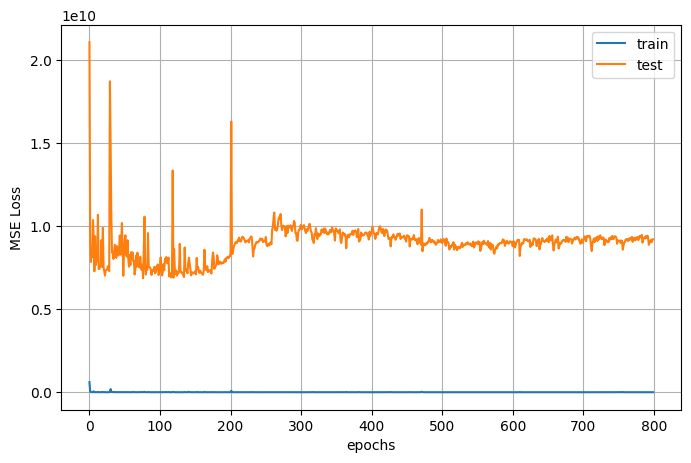

In [47]:
plt.figure(figsize=(8, 5))
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid();

In [48]:
model_c2.eval()
with torch.no_grad():
    output = model_c2(X_test)

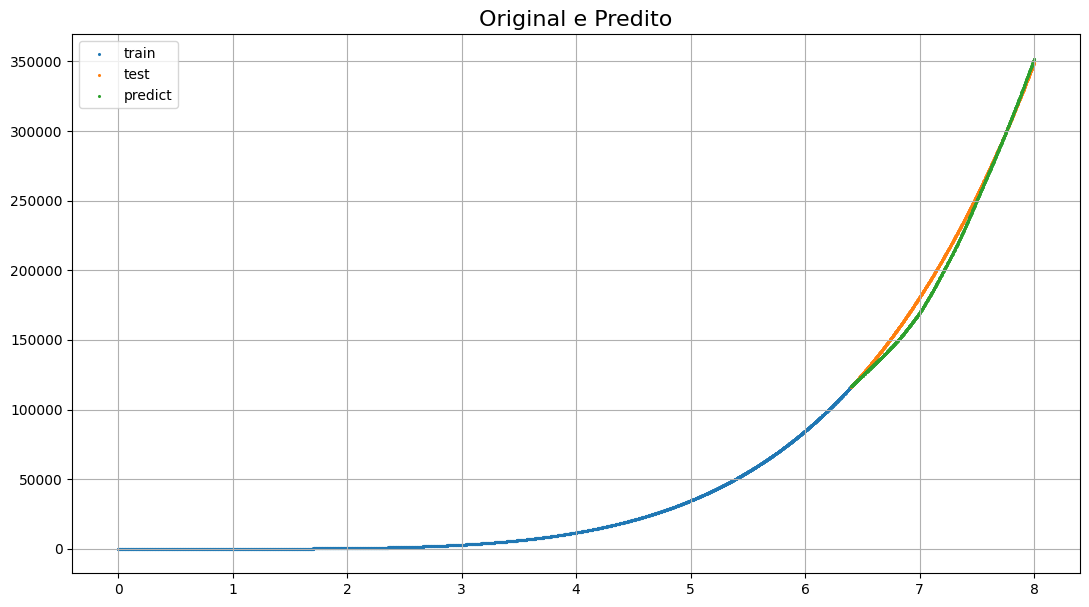

In [49]:
plt.figure(figsize=(13, 7))
plt.scatter(list(X_train.numpy().ravel()), list(y_train.numpy().ravel()), label='train', marker='o', s=1.5)
plt.scatter(list(X_test.numpy().ravel()), list(y_test.numpy().ravel()), label='test', marker='o', s=1.5)
plt.scatter(list(X_test.numpy().ravel()), list(output.numpy().ravel()), label='predict', marker='o', s=1.5)
plt.legend()
plt.title("Original e Predito", fontsize=16)
plt.grid()

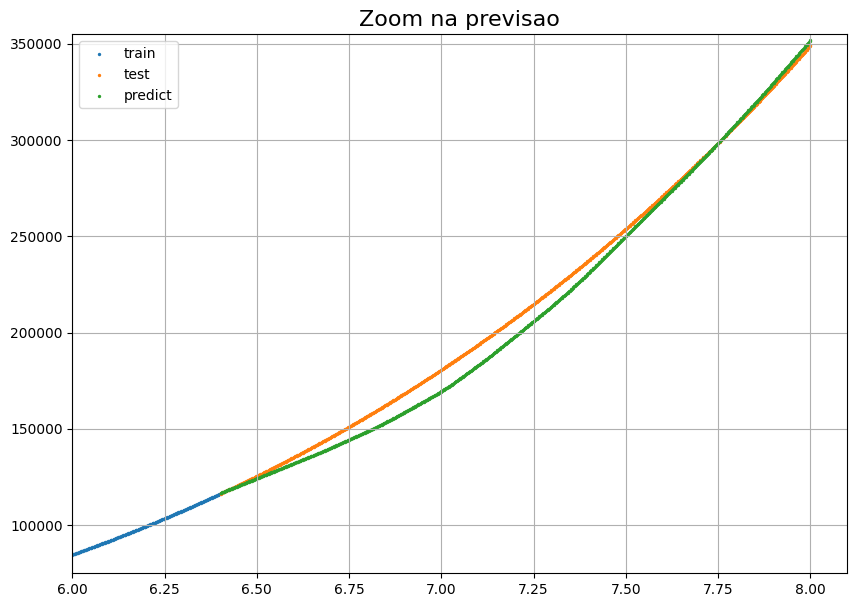

Epoch [800/800]: 100%|██████████| 40000/40000 [05:35<00:00, 121.36it/s, loss=337546.875000]

In [50]:
plt.figure(figsize=(10, 7))
plt.scatter(list(X_train.numpy().ravel()), list(y_train.numpy().ravel()), label='train', marker='o', s=2)
plt.scatter(list(X_test.numpy().ravel()), list(y_test.numpy().ravel()), label='test', marker='o', s=2)
plt.scatter(list(X_test.numpy().ravel()), list(output.numpy().ravel()), label='predict', marker='o', s=2)
plt.legend()
plt.xlim(6, 8.1)
plt.ylim(7.5e4, 3.55e5)
plt.title("Zoom na previsao", fontsize=16)
plt.grid()

In [32]:
torch.sqrt(loss_fn(output, y_test))

tensor(84118.3203)